In [2]:
# 1/20/2020 20 threads, 40G
    #read csv: wall time: 7min 45s
    #read dta: Wall time: 1h 3min 45s
    
# 1/21/2020 20 threads, 100G
    #read csv: Wall time: 5min 48s
    #read dta: Wall time: 37min 3s
    
# 1/21/2020 1:54PM, 20 threads, 100G
    #read csv: Wall time: 8min 16s
    #read dta: Wall time: 

In [3]:
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.axes as axes
import pandas as pd
import seaborn as sns
pd.set_option('display.max_rows', 20)
!date

Wed Feb 26 23:59:49 PST 2020


# 2010 census demo data. AIAN pop in urban vs rural areas: looking for the downward bias in DP counts ala Akee's findings

Akee's talk here: https://vimeo.com/380264104

In [4]:
##Encoding of the AIANHH var:
#0001–4999 Federally recognized American Indian reservation and/or off-reservation trust land
#5000–5499 Hawaiian home land 5500–5999 Oklahoma tribal statistical area
#5500–5999 Oklahoma tribal statistical area
#6000–7999 Alaska Native village statistical area
#8000–8999 Tribal designated statistical area
#9000–9499 State-recognized American Indian reservation
#9500–9998 State designated tribal statistical area 

In [5]:
location_cols = ['STATE', 'COUNTY', 'TRACT', 'BLKGRP', 'BLOCK']

race_cols = ['P0030004','P0060004'] # AIAN alone, AIAN combo
keep_cols = location_cols + race_cols

def my_cols(x):
    if x.startswith('P001'):
        return True
    elif x.startswith(('AIAN','AITS','TTRACT','UA','UR')):
        return True
    else:
        return (x in keep_cols)

In [6]:
%%time

df_dp = pd.read_csv('/home/j/temp/abie/fiftystates2010dhc.csv', usecols=my_cols)

<string>:2: DtypeWarning: Columns (28,32,33,47,49,50) have mixed types.Specify dtype option on import or set low_memory=False.


CPU times: user 8min 6s, sys: 29.6 s, total: 8min 36s
Wall time: 8min 41s


In [7]:
dta_columns = [x.lower() for x in df_dp.columns] #grab col names as lowercase
dta_columns[-3:] = df_dp.columns[-3:] #coded vars are capitalized
dta_columns #check contents

['state',
 'county',
 'tract',
 'blkgrp',
 'block',
 'aianhh',
 'aianhhfp',
 'aianhhcc',
 'aitsce',
 'aits',
 'aitscc',
 'ttract',
 'ua',
 'uasc',
 'uatype',
 'ur',
 'aianhhns',
 'aitsns',
 'aianhhsc',
 'P0010001',
 'P0030004',
 'P0060004']

In [13]:
%%time

# r = pd.read_stata('/home/j/temp/abie/all50states_2010ur1_all_vars.dta', columns=dta_columns,
#                  chunksize=100_000, convert_missing=True, preserve_dtypes=False)

# df_sf = pd.DataFrame()
# for t in r:
#     print('.', flush=True, end=' ')
#     df_sf = df_sf.append(t[t.block != ''])
# df_sf.shape

# #saved AIAN-relevant vars here; loads faster than the .dta
df_sf = pd.read_csv('/home/j/temp/beatrixh/all50states_AIAN_asian_and_urban.csv')

CPU times: user 11.1 s, sys: 2.8 s, total: 13.9 s
Wall time: 13.9 s


In [11]:
# df_sf.to_csv(r'/home/j/temp/beatrixh/all50states_AIAN_asian_and_urban.csv', index = None, header=True)

In [14]:
df_sf.columns = [x.upper() for x in df_sf.columns]
df_sf.head

<bound method NDFrame.head of           STATE  COUNTY   TRACT  BLKGRP  BLOCK  AIANHH  AIANHHFP AIANHHCC  \
0             2      13     100       1   1363    9999     99999       99   
1             2      13     100       1   1366    9999     99999       99   
2             2      13     100       1   1369    9999     99999       99   
3             2      13     100       1   1370    6030      1095       E1   
4             2      13     100       1   1371    6030      1095       E1   
...         ...     ...     ...     ...    ...     ...       ...      ...   
11071785     56      45  951100       1   1868    9999     99999       99   
11071786     56      45  951100       1   1869    9999     99999       99   
11071787     56      45  951100       1   1870    9999     99999       99   
11071788     56      45  951100       1   1871    9999     99999       99   
11071789     56      45  951100       2   2985    9999     99999       99   

          AITSCE   AITS  ...     UA UASC  UAT

In [16]:
df_sf = df_sf.drop('UASC', axis=1)
df_dp = df_dp.drop('UASC', axis=1)

In [17]:
location_cols = ['STATE', 'COUNTY', 'TRACT', 'BLKGRP', 'BLOCK', 'AIANHH']

In [21]:
block_level = pd.merge(df_sf[df_sf.BLOCK.notnull()], df_dp[df_dp.BLOCK.notnull()][location_cols + ['P0060004','P0010001','P0030004']], left_on=location_cols, right_on=location_cols, suffixes=('_SF', '_DP'))

In [22]:
block_level_aian = block_level[block_level.AIANHH!=9999]

In [23]:
block_level_aian_res_agg = block_level_aian.groupby(['AIANHH'])['P0030004_SF','P0030004_DP',
                                                                'P0060004_SF','P0060004_DP',
                                                                'P0010001_SF','P0010001_DP'].apply(lambda x : x.astype(int).sum())

/share/code/beatrixh/miniconda/envs/beatrix/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


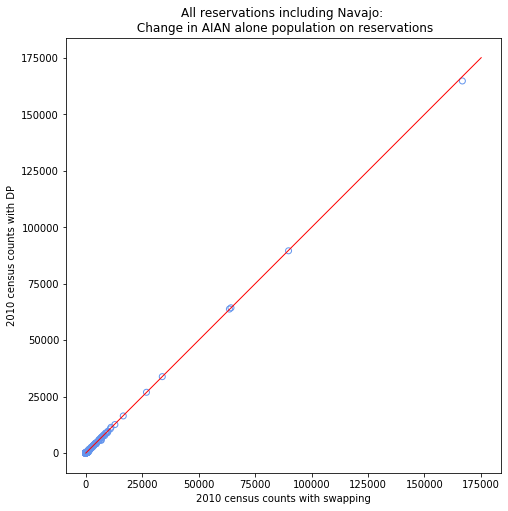

In [35]:
# overall aian on res
x = block_level_aian_res_agg[["P0030004_SF"]]
y = block_level_aian_res_agg[["P0030004_DP"]]

fig = plt.figure() 
fig.set_size_inches(8,8)

ax = fig.add_subplot(111)
ax.scatter(x, y, facecolors='none', edgecolors = 'cornflowerblue')
ax.set_aspect('equal', adjustable='box')

xleft, xright = ax.get_xlim()
ybottom, ytop = ax.get_ylim()
lim = max(xright,ytop)
ax.plot([-1,lim],[-1,lim], 'red', linewidth=1)

plt.xlabel('2010 census counts with swapping')
plt.ylabel('2010 census counts with DP')
plt.title('All reservations including Navajo: \n Change in AIAN alone population on reservations')

plt.show()

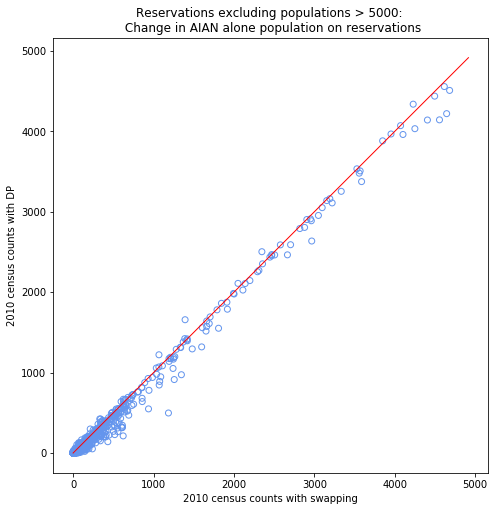

In [36]:
# zoom in
x = block_level_aian_res_agg[(block_level_aian_res_agg.P0030004_SF<5e3)|(block_level_aian_res_agg.P0030004_DP<5e3)][["P0030004_SF"]]
y = block_level_aian_res_agg[(block_level_aian_res_agg.P0030004_SF<5e3)|(block_level_aian_res_agg.P0030004_DP<5e3)][["P0030004_DP"]]

fig = plt.figure() 
fig.set_size_inches(8,8)

ax = fig.add_subplot(111)
ax.scatter(x, y, facecolors='none', edgecolors = 'cornflowerblue')
ax.set_aspect('equal', adjustable='box')

xleft, xright = ax.get_xlim()
ybottom, ytop = ax.get_ylim()
lim = max(xright,ytop)
ax.plot([-1,lim],[-1,lim], 'red', linewidth=1)

plt.xlabel('2010 census counts with swapping')
plt.ylabel('2010 census counts with DP')
plt.title('Reservations excluding populations > 5000: \n Change in AIAN alone population on reservations')

plt.show()

In [23]:
#store columns by type
float_cols = list(df_dp.loc[:, df_dp.dtypes == np.float64].columns)
int_cols = df_dp.loc[:, df_dp.dtypes == np.int64].columns

#conver df_sf to correct dtypes
df_sf.loc[:,float_cols] = df_sf.loc[:,float_cols].astype(np.float64)
df_sf.loc[:,int_cols] = df_sf.loc[:,int_cols].astype(np.int64)

#check
df_sf.dtypes

STATE         int64
COUNTY      float64
TRACT       float64
BLKGRP      float64
BLOCK       float64
             ...   
AITSNS      float64
AIANHHSC    float64
P0010001      int64
P0030005      int64
P0060004      int64
Length: 22, dtype: object

In [24]:
left = df_sf[location_cols + race_cols + ['P0010001']]
df = pd.merge(left[(left.BLOCK != '')], df_dp.dropna(subset=['BLOCK']), left_on=location_cols, right_on=location_cols, suffixes=('_SF', '_DP'))
df

/share/code/beatrixh/miniconda/envs/beatrix/lib/python3.6/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


,STATE,COUNTY,TRACT,BLKGRP,BLOCK,P0030005_SF,P0060004_SF,P0010001_SF,AIANHH,AIANHHFP,...,UA,UASC,UATYPE,UR,AIANHHNS,AITSNS,AIANHHSC,P0010001_DP,P0030005_DP,P0060004_DP
0,2,13.0,100.0,1.0,1363.0,5,0,24,9999.0,99999.0,...,99999,NaN,9,R,99999999.0,99999999.0,NaN,87,0,42
1,2,13.0,100.0,1.0,1366.0,0,0,0,9999.0,99999.0,...,99999,NaN,9,R,99999999.0,99999999.0,NaN,0,0,0
2,2,13.0,100.0,1.0,1369.0,0,0,0,9999.0,99999.0,...,99999,NaN,9,R,99999999.0,99999999.0,NaN,0,0,0
3,2,13.0,100.0,1.0,1370.0,0,0,0,6030.0,1095.0,...,99999,NaN,9,R,2418758.0,99999999.0,NaN,0,0,0
4,2,13.0,100.0,1.0,1371.0,438,27,942,6030.0,1095.0,...,99999,NaN,9,R,2418758.0,99999999.0,NaN,988,361,129
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11071785,56,45.0,951100.0,1.0,1868.0,0,0,0,9999.0,99999.0,...,99999,NaN,9,R,99999999.0,99999999.0,NaN,0,0,0
11071786,56,45.0,951100.0,1.0,1869.0,0,0,0,9999.0,99999.0,...,99999,NaN,9,R,99999999.0,99999999.0,NaN,0,0,0
11071787,56,45.0,951100.0,1.0,1870.0,0,0,0,9999.0,99999.0,...,99999,NaN,9,R,99999999.0,99999999.0,NaN,0,0,0
11071788,56,45.0,951100.0,1.0,1871.0,0,0,0,9999.0,99999.0,...,99999,NaN,9,R,99999999.0,99999999.0,NaN,0,0,0


In [25]:
#subset to urban areas, grouped by county
urban_county = df[df.UR== 'U'].copy(deep=True)
urban_county = urban_county.groupby(['STATE','COUNTY'])['P0030005_SF','P0030005_DP',
                                                        'P0060004_SF','P0060004_DP',
                                                        'P0010001_SF','P0010001_DP'].apply(lambda x : x.astype(int).sum())

/share/code/beatrixh/miniconda/envs/beatrix/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """


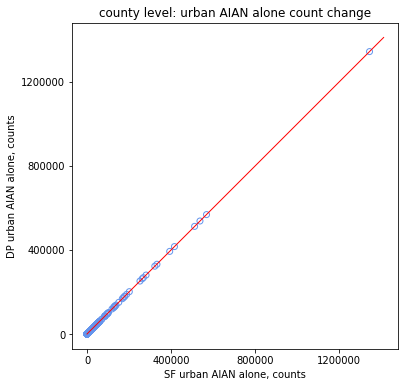

In [26]:
x = urban_county[["P0030005_SF"]]
y = urban_county[["P0030005_DP"]]

fig = plt.figure() 
fig.set_size_inches(6,6)

ax = fig.add_subplot(111)
ax.scatter(x, y, facecolors='none', edgecolors = 'cornflowerblue')
ax.set_aspect('equal', adjustable='box')

plt.xticks(np.arange(0, 1.4e6, step = 4e5))
plt.yticks(np.arange(0, 1.4e6, step = 4e5))

xleft, xright = ax.get_xlim()
ybottom, ytop = ax.get_ylim()
ax.plot([-1,xright],[-1,ytop], 'red', linewidth=1)

plt.xlabel('SF urban AIAN alone, counts')
plt.ylabel('DP urban AIAN alone, counts')
plt.title('county level: urban AIAN alone count change')

plt.show()

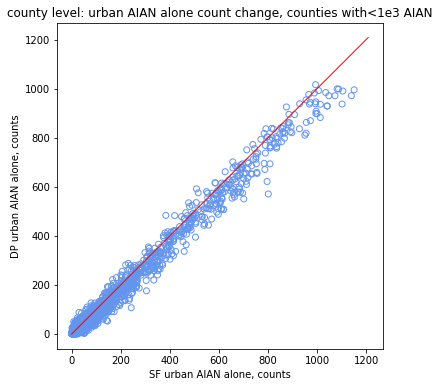

In [27]:
#let's zoom in
x = urban_county[(urban_county.P0030005_DP<1e3) | (urban_county.P0030005_SF<1e3)][["P0030005_SF"]]
y = urban_county[(urban_county.P0030005_DP<1e3) | (urban_county.P0030005_SF<1e3)][["P0030005_DP"]]

fig = plt.figure() 
fig.set_size_inches(6,6)

ax = fig.add_subplot(111)
ax.scatter(x, y, facecolors='none', edgecolors = 'cornflowerblue')
ax.set_aspect('equal', adjustable='box')

xleft, xright = ax.get_xlim()
ybottom, ytop = ax.get_ylim()
lim = max(xright,ytop)
ax.plot([-1,lim],[-1,lim], 'red', linewidth=1)

plt.xlabel('SF urban AIAN alone, counts')
plt.ylabel('DP urban AIAN alone, counts')
plt.title('county level: urban AIAN alone count change, counties with<1e3 AIAN')

plt.show()

## vs rural

In [28]:
#subset to rural areas, grouped by county
rural_county = df[df.UR== 'R'].copy(deep=True)
rural_county = rural_county.groupby(['STATE','COUNTY'])['P0030005_SF','P0030005_DP',
                                                        'P0060004_SF','P0060004_DP',
                                                        'P0010001_SF','P0010001_DP'].apply(lambda x : x.astype(int).sum())

/share/code/beatrixh/miniconda/envs/beatrix/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """


In [29]:
#plot urban areas by tract, dp vs sf
x = rural_county[["P0030005_SF"]]
y = rural_county[["P0030005_DP"]]

fig = plt.figure() 
fig.set_size_inches(6,6)

ax = fig.add_subplot(111)
ax.scatter(x, y, facecolors='none', edgecolors = 'cornflowerblue')
ax.set_aspect('equal', adjustable='box')

xleft, xright = ax.get_xlim()
ybottom, ytop = ax.get_ylim()
lim = max(xright,ytop)
ax.plot([-1,lim],[-1,lim], 'red', linewidth=1)

plt.xlabel('SF rural AIAN alone, counts')
plt.ylabel('DP rural AIAN alone, counts')
plt.title('county level: rural AIAN alone count change')

plt.show()

KeyboardInterrupt: 

In [ ]:
#zooming in
x = rural_county[(rural_county.P0030005_DP<3e3) | (rural_county.P0030005_SF<3e3)][["P0030005_SF"]]
y = rural_county[(rural_county.P0030005_DP<3e3) | (rural_county.P0030005_SF<3e3)][["P0030005_DP"]]

fig = plt.figure() 
fig.set_size_inches(6,6)

ax = fig.add_subplot(111)
ax.scatter(x, y, facecolors='none', edgecolors = 'cornflowerblue')
ax.set_aspect('equal', adjustable='box')

xleft, xright = ax.get_xlim()
ybottom, ytop = ax.get_ylim()
lim = max(xright,ytop)
ax.plot([-1,lim],[-1,lim], 'red', linewidth=1)

plt.xlabel('SF rural AIAN alone, counts')
plt.ylabel('DP rural AIAN alone, counts')
plt.title('county level: rural AIAN alone count change, counties with<3e3 AIAN')

plt.show()

## now back to urban:

In [ ]:
#check out count difference
urban_county['abs_diff'] = urban_county['P0030005_DP'] - urban_county['P0030005_SF']

#plot histogram
fig = plt.figure()
ax = fig.add_subplot(111)
plt.hist(urban_county[(urban_county.P0030005_DP!=0) | (urban_county.P0030005_SF!=0)].abs_diff, bins = 100)

plt.title('County level; urban AIAN count difference, excluding points that remained at 0.')

plt.show() 

In [ ]:
#zoom in (counts in log space)
fig = plt.figure()
ax = fig.add_subplot(111)
plt.hist(urban_county[(urban_county.P0030005_DP!=0) | (urban_county.P0030005_SF!=0)].abs_diff, bins = 100)
plt.yscale('log')

plt.title('County level; urban AIAN count difference, excluding points that remained at 0.')

plt.show() 

In [ ]:
#subset to urban areas, grouped by county
urban_tract = df[df.UR== 'U'].copy(deep=True)
urban_tract = urban_tract.groupby(['STATE','COUNTY','TRACT'])['P0030005_SF','P0030005_DP',
                                                              'P0060004_SF','P0060004_DP',
                                                              'P0010001_SF','P0010001_DP'].apply(lambda x : x.astype(int).sum())

In [ ]:
#plot urban areas by tract, dp vs sf
x = urban_tract[["P0030005_SF"]]
y = urban_tract[["P0030005_DP"]]

fig = plt.figure() 
fig.set_size_inches(6,6)

ax = fig.add_subplot(111)
ax.scatter(x, y, facecolors='none', edgecolors = 'cornflowerblue')
ax.set_aspect('equal', adjustable='box')

xleft, xright = ax.get_xlim()
ybottom, ytop = ax.get_ylim()
lim = max(xright,ytop)
ax.plot([-1,lim],[-1,lim], 'red', linewidth=1)

plt.xlabel('SF urban AIAN alone, counts')
plt.ylabel('DP urban AIAN alone, counts')
plt.title('tract level: urban AIAN alone count change')

plt.show()

In [ ]:
#check out count difference
urban_tract['abs_diff'] = urban_tract['P0030005_DP'] - urban_tract['P0030005_SF']

#plot histogram
fig = plt.figure()
ax = fig.add_subplot(111)
plt.hist(urban_tract[(urban_tract.P0030005_DP!=0) | (urban_tract.P0030005_SF!=0)].abs_diff, bins = 100)

plt.title('Tract level; urban AIAN count difference, excluding points that remained at 0.')

plt.show() 

In [ ]:
urban_county.abs_diff.describe()

In [ ]:
#zooming in (this is same as above scatter)
urban_county[(urban_county.P0030005_DP<5e2) | (urban_county.P0030005_SF<5e2)].abs_diff.describe()

In [ ]:
#zoom in (counts in log space)
urban_tract['abs_diff'] = urban_tract['P0030005_DP'] - urban_tract['P0030005_SF']

#plot histogram
fig = plt.figure()
ax = fig.add_subplot(111)
plt.hist(urban_tract[(urban_tract.P0030005_DP!=0) | (urban_tract.P0030005_SF!=0)].abs_diff, bins = 100)
plt.yscale('log')

plt.title('Tract level; urban AIAN count difference, excluding points that remained at 0.')

plt.show() 

## checkout AIAN in combo (solely AIAN + AIAN mixed individuals)

In [ ]:
#check out AIAN in combo, county level counts change
x = urban_county[["P0060004_SF"]]
y = urban_county[["P0060004_DP"]]

fig = plt.figure() 
fig.set_size_inches(6,6)

ax = fig.add_subplot(111)
ax.scatter(x, y, facecolors='none', edgecolors = 'cornflowerblue')
ax.set_aspect('equal', adjustable='box')

xleft, xright = ax.get_xlim()
ybottom, ytop = ax.get_ylim()
lim = max(xright,ytop)
ax.plot([-1,lim],[-1,lim], 'red', linewidth=1)

xleft, xright = ax.get_xlim()
ybottom, ytop = ax.get_ylim()
ax.plot([-1,xright],[-1,ytop], 'red', linewidth=1)

plt.xlabel('SF urban AIAN alone, counts')
plt.ylabel('DP urban AIAN alone, counts')
plt.title('county level: urban AIAN in combo count change')

plt.show()

In [ ]:
#zooming in

#check out AIAN in combo, county level counts change
x = urban_county[(urban_county.P0060004_DP<6e4) | (urban_county.P0060004_SF<6e4)][["P0060004_SF"]]
y = urban_county[(urban_county.P0060004_DP<6e4) | (urban_county.P0060004_SF<6e4)][["P0060004_DP"]]

fig = plt.figure() 
fig.set_size_inches(6,6)

ax = fig.add_subplot(111)
ax.scatter(x, y, facecolors='none', edgecolors = 'cornflowerblue')
ax.set_aspect('equal', adjustable='box')

xleft, xright = ax.get_xlim()
ybottom, ytop = ax.get_ylim()
lim = max(xright,ytop)
ax.plot([-1,lim],[-1,lim], 'red', linewidth=1)

xleft, xright = ax.get_xlim()
ybottom, ytop = ax.get_ylim()
ax.plot([-1,xright],[-1,ytop], 'red', linewidth=1)

plt.xlabel('SF urban AIAN alone, counts')
plt.ylabel('DP urban AIAN alone, counts')
plt.title('county level: urban AIAN in combo count change, for mixed counts <6e4')

plt.show()

In [ ]:
#zooming in

#check out AIAN in combo, county level counts change
x = urban_county[(urban_county.P0060004_DP<5e3) | (urban_county.P0060004_SF<5e3)][["P0060004_SF"]]
y = urban_county[(urban_county.P0060004_DP<5e3) | (urban_county.P0060004_SF<5e3)][["P0060004_DP"]]

fig = plt.figure() 
fig.set_size_inches(6,6)

ax = fig.add_subplot(111)
ax.scatter(x, y, facecolors='none', edgecolors = 'cornflowerblue')
ax.set_aspect('equal', adjustable='box')

xleft, xright = ax.get_xlim()
ybottom, ytop = ax.get_ylim()
lim = max(xright,ytop)
ax.plot([-1,lim],[-1,lim], 'red', linewidth=1)

xleft, xright = ax.get_xlim()
ybottom, ytop = ax.get_ylim()
ax.plot([-1,xright],[-1,ytop], 'red', linewidth=1)

plt.xlabel('SF urban AIAN alone, counts')
plt.ylabel('DP urban AIAN alone, counts')
plt.title('county level: urban AIAN in combo count change, for mixed counts<2e4')

plt.show()

## View DP-SF difference as a function of AIAN count

In [ ]:
urban_county["abs_diff_aian_combo"] = urban_county["P0060004_DP"] - urban_county["P0060004_SF"]

#check out AIAN in combo, county level counts change
x = urban_county[["P0060004_SF"]]
y = urban_county[["abs_diff_aian_combo"]]

fig = plt.figure() 
fig.set_size_inches(6,6)

ax = fig.add_subplot(111)
ax.scatter(x, y, facecolors='none', edgecolors = 'cornflowerblue')

xleft, xright = ax.get_xlim()
ax.plot([0,xright],[0,0], 'red', linewidth=1)

plt.xlabel('SF urban AIAN alone, counts')
plt.ylabel('change in DP count from SF')
plt.title('county level: urban AIAN in combo count change')

plt.show()

In [ ]:
#zooming in 

#check out AIAN alone, county level counts change
x = urban_county[["P0030005_SF"]]
y = urban_county[["abs_diff"]]

fig = plt.figure() 
fig.set_size_inches(6,6)

ax = fig.add_subplot(111)
ax.scatter(x, y, facecolors='none', edgecolors = 'cornflowerblue')

xleft, xright = ax.get_xlim()
ax.plot([0,xright],[0,0], 'red', linewidth=1)


plt.xlabel('SF urban AIAN alone, counts')
plt.ylabel('change in DP count from SF')
plt.title('county level: urban AIAN alone count change')

plt.show()

In [ ]:
#zooming in 

#check out AIAN alone, county level counts change
x = urban_county[(urban_county.P0030005_SF<2e5)][["P0030005_SF"]]
y = urban_county[(urban_county.P0030005_SF<2e5)][["abs_diff"]]

fig = plt.figure() 
fig.set_size_inches(6,6)

ax = fig.add_subplot(111)
ax.scatter(x, y, facecolors='none', edgecolors = 'cornflowerblue')

xleft, xright = ax.get_xlim()
ax.plot([0,xright],[0,0], 'red', linewidth=1)


plt.xlabel('SF urban AIAN alone, counts')
plt.ylabel('change in DP count from SF')
plt.title('county level: urban AIAN alone count change for counties with <2e5 AIAN alone')

plt.show()

In [ ]:
#todo: you need to checkout the distribution of urban aian, and also on-res aian
#to see if it looks like what you were seeing with toy data.

In [ ]:
urban_county.size

# checkout aian urban overall distribution

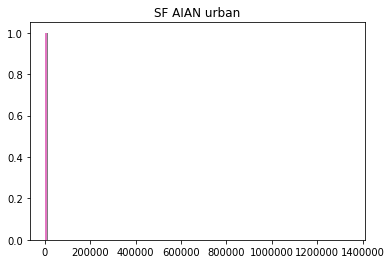

In [30]:
#check out AIAN alone, county level counts change
x = urban_county[["P0030005_SF"]]

plt.hist(x, bins = 100)
plt.title('SF AIAN urban')

plt.show()

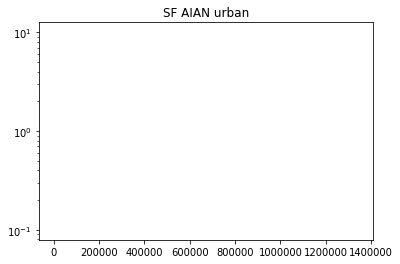

In [33]:
#check out AIAN alone, county level counts change
x = urban_county[["P0030005_SF"]]

plt.hist(x, bins = 500, log = True)
plt.title('SF AIAN urban')

plt.show()